In [8]:
%matplotlib widget

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import trange

In [10]:
class BouncingBallEnv(object):

    def __init__(self, rows, cols, radius, MOVE=False, NOISE=False):
        self.rows, self.cols = rows, cols
        self.ball_x, self.ball_y = math.floor(rows/2),math.floor(cols/2)
        self.radius = radius
        self.vx = 0.25
        self.vy = 0.25
        self.t = 0
        self.MOVE = MOVE
        self.NOISE = NOISE

    def next_batch(self):
        events = []
        self.t += 1
        if self.MOVE:
            self.ball_x, self.ball_y = self.ball_x + self.vx, self.ball_y + self.vy
            if self.ball_x + self.radius >= self.rows-1:
                self.vx = self.vx + np.random.uniform(-0.01,0.01)
                self.vx *= -1
                self.ball_x = self.rows-1-self.radius

            if self.ball_y + self.radius >= self.cols-1:
                self.vy = self.vy + np.random.uniform(-0.01,0.01)
                self.vy *= -1
                self.ball_y = self.cols-1-self.radius

            if self.ball_x - self.radius <= 0:
                self.vx = self.vx + np.random.uniform(-0.01,0.01)
                self.vx *= -1
                self.ball_x = 0+self.radius

            if self.ball_y - self.radius <= 0:
                self.vy = self.vy + np.random.uniform(-0.01,0.01)
                self.vy *= -1
                self.ball_y = 0+self.radius
        for i in range(50):
            if np.random.rand() > 0.5 or not self.NOISE:
                theta = np.random.uniform(0,math.pi*2)
                dx, dy = self.radius*math.cos(theta), self.radius*math.sin(theta)
                x, y = math.floor(self.ball_x + dx), math.floor(self.ball_y + dy)
            else:
                x,y = np.random.randint(0,self.rows), np.random.randint(0,self.cols)
            events.append((x,y,self.t))

        return events

    def reset(self):
        self.ball_x, self.ball_y = math.floor(self.rows/2),math.floor(self.cols/2)
        self.vx = 0.25
        self.vy = 0.25
        self.t = 0

In [15]:
class FEAST:
    def __init__(self, sensor_rows, sensor_cols, roi_rows, roi_cols, tau, n_neurons,  eta, threshold_close, threshold_open):
        # Dimensions
        self.rows = sensor_rows
        self.cols = sensor_cols
        self.roi_rows = roi_rows
        self.roi_cols = roi_cols
        self.context_size = self.roi_rows*self.roi_cols
        
        #Hyper parameters
        self.tau = tau
        self.n_neurons = n_neurons
        self.eta  = eta
        self.threshold_close = threshold_close 
        self.threshold_open = threshold_open
        
        #Parameters
        self.w = np.random.rand(self.n_neurons,self.context_size)
        self.w = np.divide(self.w,np.linalg.norm(self.w,axis=1,keepdims=True))
        self.thresh = np.random.rand(self.n_neurons,1)
        
        self.timestamps = np.zeros((self.rows,self.cols),dtype=np.int64)
        self.polarity = np.zeros((self.rows,self.cols))
        
    def process(self,x,y,p,t):
        self.polarity[x,y] = p
        self.timestamps[x,y] = t
        
        row_radius = int((self.roi_rows -1)/2)
        col_radius = int((self.roi_cols - 1)/2)
        
        # If the event x,y location is not at the edge where you can't take the roi
        if x-row_radius>= 0 and x+row_radius < self.rows and y-col_radius >= 0 and y + col_radius < self.cols:
            
            # Calculate the time surface of window around the current event location
            roi_surface = np.multiply(self.polarity[x-row_radius:x+row_radius+1, y-col_radius:y+col_radius+1],
                                 np.exp((self.timestamps[x-row_radius:x+row_radius+1, y-col_radius:y+col_radius+1] - t)/tau))
            
            # Normalize the time surface
            roi_surface = roi_surface/np.linalg.norm(roi_surface)
            # print(roi_surface.shape)
            # Find the dot prodcut of the time surface context and weights
            dotProduct = np.matmul(self.w,roi_surface.reshape(-1,1))
            
            
            if np.all(np.less(dotProduct,self.thresh)):
                # If the dot product values of all neurons are below the threshold, then no winner
                winnerNeuron = -1
                # Lower the thresholds of all the neurons
                self.thresh = self.thresh - self.threshold_open
                
            else:
                # Find the neuron with highest dot product value among the neurons which crossed the threshold
                dotProduct[dotProduct < self.thresh] = -np.inf
                winnerNeuron = int(np.argmax(dotProduct))
                
                # Update weights and thresholds
                self.w[winnerNeuron,:] = self.w[winnerNeuron,:] + self.eta*(roi_surface.reshape(1,-1) - self.w[winnerNeuron,:])
                self.w[winnerNeuron,:] = self.w[winnerNeuron,:]/np.linalg.norm(self.w[winnerNeuron,:])
                
                # Increase the threshold of the winner neuron
                self.thresh[winnerNeuron] = self.thresh[winnerNeuron] + self.threshold_close 
                
        else:
            winnerNeuron = -1
            
        return winnerNeuron
        

In [12]:

#Flags
COLORS = True
# COLORS = False
MOVE = True
NOISE = True


rows = 100
cols = 100

radius = 5
env  = BouncingBallEnv(rows,cols,radius,MOVE,NOISE)

sim_tim = 10000
disp_t  =0
disp_freq = 10



TS = np.zeros((rows,cols))
env.reset()


roi_shape = (5,5)
n_neurons = 18
eta = 0.01
threshold_open = 0.2
threshold_close = 0.02
tau = 10

np.random.seed(0)
feast_layer = FEAST(rows, cols, roi_shape[0], roi_shape[1], tau, n_neurons,  eta, threshold_close, threshold_open)


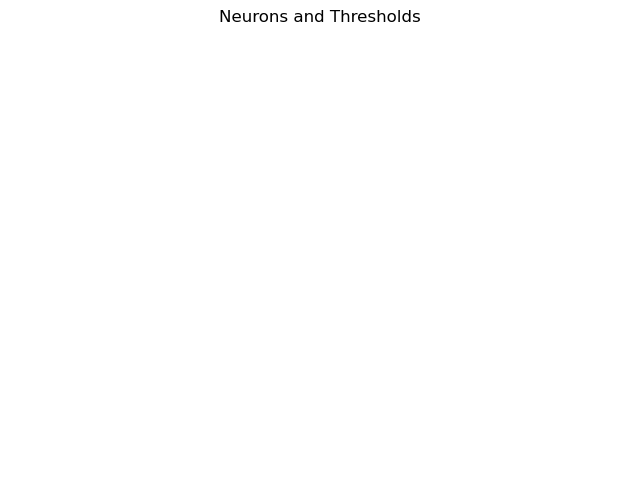

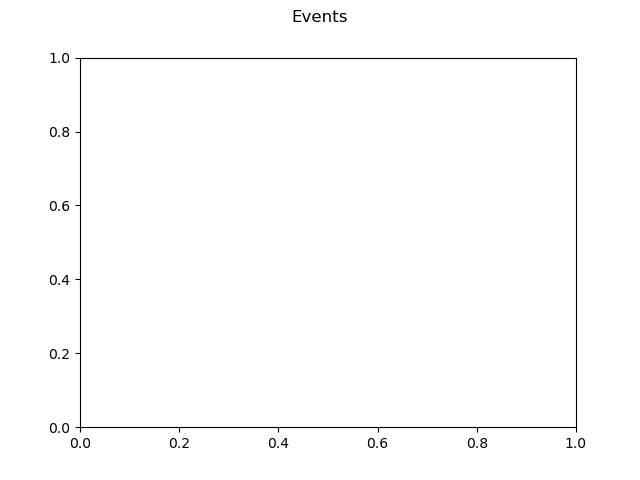

In [13]:
missed_rate = 0

# Plotting stuff
fig_r, fig_c = math.ceil(math.sqrt(n_neurons)), math.ceil(math.sqrt(n_neurons))

fig, axs = plt.subplots(fig_r,fig_c)
fig.suptitle("Neurons and Thresholds")
for ax in axs:
    for a in ax:
        a.axis("off")

fig_2,axs_2 = plt.subplots(1,1)
fig_2.suptitle("Events")
img  = np.full((int(rows),int(cols),3), fill_value=0,dtype='uint8')
def colorPaletteGenerator(nNeuron,colors):
    # random_numbers = np.random.randint(low=0, high=256, size=(nNeuron, 3))
    generated_colours = [tuple(colour) for colour in colors[:nNeuron]]
    return generated_colours
colors = [[166,206,227],
[31,120,180],
[178,223,138],
[51,160,44],
[251,154,153],
[227,26,28],
[253,191,111],
[255,127,0],
[202,178,214],
[106,61,154],
[178,223,138],
[51,160,44],
[251,154,153],
[227,26,28],
[253,191,111],
[255,127,0],
[202,178,214],
[106,61,154],
[255,127,0],
[202,178,214],
[106,61,154],
[178,223,138],
[51,160,44],
[251,154,153],
[227,26,28],
[253,191,111],
[255,127,0],
[202,178,214],
[106,61,154]
]
generatedPalette = colorPaletteGenerator(n_neurons+1,colors)

In [14]:
pbar = trange(sim_tim)
for step in pbar:
    events = env.next_batch()
    for event in events:
        x,y,t = event
        p = 1
        TS[x,y] = t
        winnerNeuron = feast_layer.process(x,y,p,t)
        img[x,y,:] = generatedPalette[winnerNeuron]

        if winnerNeuron > -1:
            missed_rate = 0.99*missed_rate
            # correct_class += 1
        else:
            missed_rate = 0.99*missed_rate + 0.01
            # no_class += 1
    if t > disp_t:
        pbar.set_description("Missed Rate:{}".format(missed_rate))
        disp_t += disp_freq
        surface = np.exp((TS-t)/tau)
        # fig.clear()
        for i in range(feast_layer.n_neurons):
            plt_x, plt_y = np.unravel_index(i,(fig_r,fig_c))
            axs[plt_x,plt_y].imshow(feast_layer.w[i,:].reshape(feast_layer.roi_rows, feast_layer.roi_cols))
            axs[plt_x,plt_y].set_title("{:.2f}".format(feast_layer.thresh[i,0]))
        # plt.pause(0.1)
        fig.canvas.draw_idle()
        if COLORS:
            axs_2.imshow(img)
        else:
            axs_2.imshow(surface)
        img *= 0
        fig_2.canvas.draw_idle()
        # axs[]
        # plt.imshow(surface)
        # plt.pause(0.1)

print("Done!")

Missed Rate:0.04997057722197738: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 457.90it/s]

Done!
